In [1]:
!conda info


     active environment : kpose
    active env location : /home/aiffel0042/anaconda3/envs/kpose
            shell level : 3
       user config file : /home/aiffel0042/.condarc
 populated config files : 
          conda version : 4.8.2
    conda-build version : 3.18.11
         python version : 3.7.6.final.0
       virtual packages : __cuda=11.0
                          __glibc=2.27
       base environment : /home/aiffel0042/anaconda3  (writable)
           channel URLs : https://repo.anaconda.com/pkgs/main/linux-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/linux-64
                          https://repo.anaconda.com/pkgs/r/noarch
          package cache : /home/aiffel0042/anaconda3/pkgs
                          /home/aiffel0042/.conda/pkgs
       envs directories : /home/aiffel0042/anaconda3/envs
                          /home/aiffel0042/.conda/envs
               platform : linux-64
             

In [2]:
%load_ext autoreload
%autoreload 2
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["figure.dpi"] = 125
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})

In [3]:
%matplotlib inline
import tf_pose
import cv2
from glob import glob
from tqdm import tqdm_notebook
from PIL import Image
import numpy as np
import os
def video_gen(in_path):
    c_cap = cv2.VideoCapture(in_path)
    while c_cap.isOpened():
        ret, frame = c_cap.read()
        if not ret:
            break
        yield c_cap.get(cv2.CAP_PROP_POS_MSEC), frame[:, :, ::-1]
    c_cap.release()

In [16]:
video_paths = glob('../input/*.mp4')
c_video = video_gen(video_paths[0])


In [17]:
video_paths

['../input/bandicam 2020-12-02 17-13-27-200.mp4',
 '../input/bandicam 2020-12-02 17-20-11-544.mp4']

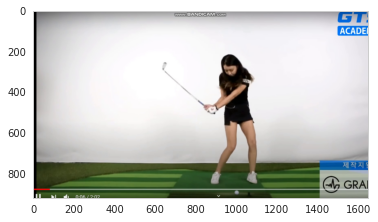

In [18]:
for _ in range(100):
    c_ts, c_frame = next(c_video)
plt.imshow(c_frame)

In [19]:
from tf_pose.estimator import TfPoseEstimator
from tf_pose.networks import get_graph_path, model_wh
tfpe = tf_pose.get_estimator()

In [20]:
humans = tfpe.inference(npimg=c_frame, upsample_size=4.0)
print(humans)

[BodyPart:0-(0.58, 0.32) score=0.67 BodyPart:1-(0.59, 0.35) score=0.85 BodyPart:2-(0.56, 0.34) score=0.65 BodyPart:3-(0.56, 0.43) score=0.51 BodyPart:4-(0.53, 0.50) score=0.56 BodyPart:5-(0.62, 0.35) score=0.71 BodyPart:6-(0.59, 0.44) score=0.57 BodyPart:7-(0.54, 0.50) score=0.63 BodyPart:8-(0.58, 0.55) score=0.60 BodyPart:9-(0.58, 0.71) score=0.67 BodyPart:10-(0.54, 0.85) score=0.72 BodyPart:11-(0.62, 0.55) score=0.61 BodyPart:12-(0.65, 0.70) score=0.90 BodyPart:13-(0.65, 0.85) score=0.75 BodyPart:14-(0.56, 0.30) score=0.72 BodyPart:15-(0.59, 0.30) score=0.67 BodyPart:17-(0.61, 0.29) score=0.55]


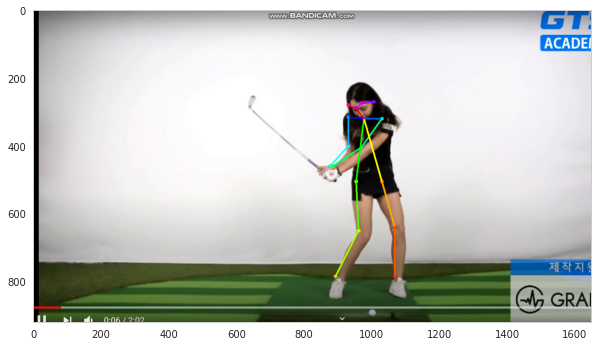

In [21]:
new_image = TfPoseEstimator.draw_humans(c_frame[:, :, ::-1], humans, imgcopy=False)
fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))
ax1.imshow(new_image[:, :, ::-1])

In [22]:
body_to_dict = lambda c_fig: {'bp_{}_{}'.format(k, vec_name): vec_val 
                              for k, part_vec in c_fig.body_parts.items() 
                              for vec_name, vec_val in zip(['x', 'y', 'score'],
                                                           (part_vec.x, 1-part_vec.y, part_vec.score))}
c_fig = humans[0]
body_to_dict(c_fig)

{'bp_0_x': 0.5787037037037037,
 'bp_0_y': 0.6847826086956521,
 'bp_0_score': 0.67153400182724,
 'bp_1_x': 0.5925925925925926,
 'bp_1_y': 0.6521739130434783,
 'bp_1_score': 0.8504887223243713,
 'bp_2_x': 0.5648148148148148,
 'bp_2_y': 0.6576086956521738,
 'bp_2_score': 0.6480457186698914,
 'bp_3_x': 0.5648148148148148,
 'bp_3_y': 0.5652173913043479,
 'bp_3_score': 0.5147388577461243,
 'bp_4_x': 0.5324074074074074,
 'bp_4_y': 0.5,
 'bp_4_score': 0.5629224181175232,
 'bp_5_x': 0.625,
 'bp_5_y': 0.6521739130434783,
 'bp_5_score': 0.7052580118179321,
 'bp_6_x': 0.5879629629629629,
 'bp_6_y': 0.5597826086956521,
 'bp_6_score': 0.5684341788291931,
 'bp_7_x': 0.5370370370370371,
 'bp_7_y': 0.5,
 'bp_7_score': 0.6262767910957336,
 'bp_8_x': 0.5787037037037037,
 'bp_8_y': 0.45108695652173914,
 'bp_8_score': 0.5956510305404663,
 'bp_9_x': 0.5833333333333334,
 'bp_9_y': 0.2934782608695652,
 'bp_9_score': 0.6688433885574341,
 'bp_10_x': 0.5416666666666666,
 'bp_10_y': 0.1467391304347826,
 'bp_10_sc

In [23]:
MAX_FRAMES = 200
body_pose_list = []
for vid_path in tqdm_notebook(video_paths, desc='Files'):
    c_video = video_gen(vid_path)
    c_ts, c_frame = next(c_video)
    out_path = '{}_out.avi'.format(os.path.split(vid_path)[1])
    out = cv2.VideoWriter(out_path,
                          cv2.VideoWriter_fourcc('M','J','P','G'),
                          10, 
                          (c_frame.shape[1], c_frame.shape[0]))
    for (c_ts, c_frame), _ in zip(c_video, 
                                  tqdm_notebook(range(MAX_FRAMES), desc='Frames')):
        bgr_frame = c_frame[:,:,::-1]
        humans = tfpe.inference(npimg=bgr_frame, upsample_size=4.0)
        for c_body in humans:
            body_pose_list += [dict(video=out_path, time=c_ts, **body_to_dict(c_body))]
        new_image = TfPoseEstimator.draw_humans(bgr_frame, humans, imgcopy=False)
        out.write(new_image)
    out.release()

/home/aiffel0042/anaconda3/envs/kpose/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/home/aiffel0042/anaconda3/envs/kpose/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


In [24]:
import pandas as pd
body_pose_df = pd.DataFrame(body_pose_list)
body_pose_df.describe()

,time,bp_0_x,bp_0_y,bp_0_score,bp_1_x,bp_1_y,bp_1_score,bp_2_x,bp_2_y,bp_2_score,...,bp_14_score,bp_15_x,bp_15_y,bp_15_score,bp_16_x,bp_16_y,bp_16_score,bp_17_x,bp_17_y,bp_17_score
count,295.000000,293.000000,293.000000,293.000000,295.000000,295.000000,295.000000,294.000000,294.000000,294.000000,...,293.000000,217.000000,217.000000,217.000000,275.000000,275.000000,275.000000,193.000000,193.000000,193.000000
mean,2522.120678,0.576697,0.763411,0.788452,0.568330,0.712657,0.760755,0.549131,0.708611,0.718020,...,0.805453,0.575034,0.756487,0.747321,0.550758,0.780336,0.574471,0.584749,0.761517,0.570114
std,1463.683782,0.042343,0.061446,0.084985,0.034264,0.048113,0.075076,0.036825,0.050573,0.095836,...,0.090206,0.036065,0.045078,0.169494,0.040466,0.053455,0.150626,0.028898,0.046392,0.083183
min,33.300000,0.495370,0.679348,0.227372,0.513889,0.641304,0.524415,0.481481,0.635870,0.315781,...,0.305032,0.504630,0.690217,0.140741,0.467593,0.690217,0.128286,0.523148,0.701087,0.195516
25%,1283.300000,0.537037,0.706522,0.747584,0.541667,0.668478,0.712151,0.504630,0.663043,0.662543,...,0.766191,0.546296,0.722826,0.748224,0.509259,0.728261,0.462860,0.560185,0.722826,0.542684
50%,2500.000000,0.578704,0.771739,0.758696,0.569444,0.706522,0.784460,0.555556,0.698370,0.756693,...,0.799063,0.583333,0.722826,0.774099,0.550926,0.771739,0.612307,0.597222,0.728261,0.564666
75%,3749.966667,0.587963,0.788043,0.858125,0.592593,0.744565,0.821741,0.578704,0.739130,0.775792,...,0.862793,0.597222,0.804348,0.840771,0.564815,0.815217,0.691233,0.615741,0.815217,0.578406
max,5366.633333,0.662037,0.875000,0.954569,0.634259,0.793478,0.937757,0.652778,0.804348,0.887061,...,1.016916,0.662037,0.864130,0.980417,0.629630,0.869565,0.909722,0.625000,0.858696,0.856145


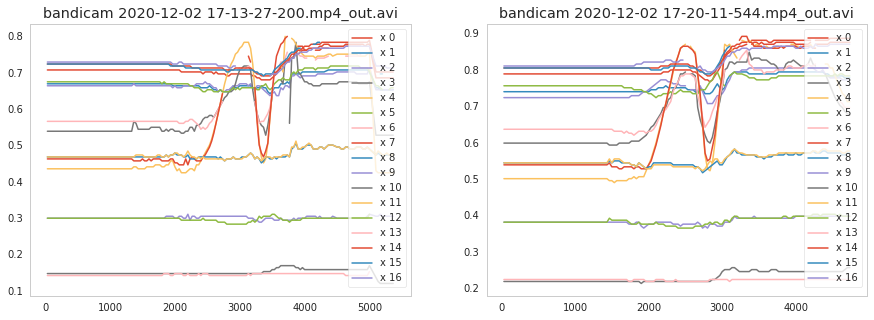

In [25]:
fig, m_axs = plt.subplots(1, 2, figsize=(15, 5))
for c_ax, (c_name, c_rows) in zip(m_axs, body_pose_df.groupby('video')):
    for i in range(17):
        c_ax.plot(c_rows['time'], c_rows['bp_{}_y'.format(i)], label='x {}'.format(i))
    c_ax.legend()
    c_ax.set_title(c_name)

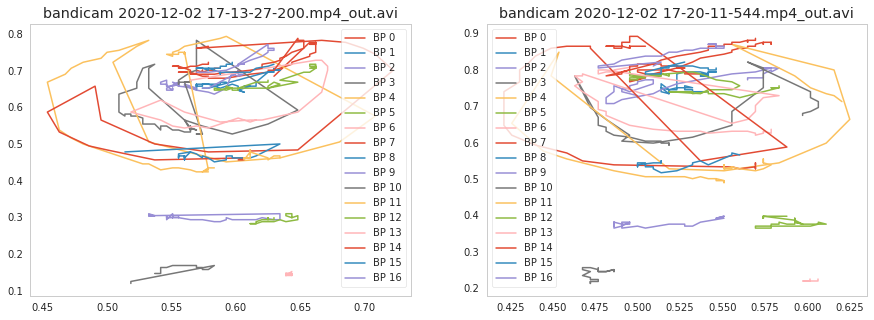

In [26]:
fig, m_axs = plt.subplots(1, 2, figsize=(15, 5))
for c_ax, (c_name, n_rows) in zip(m_axs, body_pose_df.groupby('video')):
    for i in range(17):
        c_rows = n_rows.query('bp_{}_score>0.6'.format(i)) # only keep confident results
        c_ax.plot(c_rows['bp_{}_x'.format(i)], c_rows['bp_{}_y'.format(i)], label='BP {}'.format(i))
    c_ax.legend()
    c_ax.set_title(c_name)